In [1]:
import numpy as np
import scipy as sp
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
import os
from PIL import Image
import cv2
import glob
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Activation
from tensorflow.keras import Model, datasets, layers, models
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from io import StringIO

For this project, I used public dataset of Chest Xray Pneumonia from Kaggle
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
The dataset has three folders of train, test, and val. My entire image dataset is from train folder. Note: Due to the large amount of data, I didn't include the image files. 

In [2]:
imgage_path = 'train/'

width = 100
height = 100
channel=3

raw_image =[]
processed_image =[]
count =0 
labels=[]

for dirc in sorted (os.listdir('train/')):
    print('starting to read from train/'+str(dirc))
    img_path = 'train/'+str(dirc)+'/*.jpeg'
    file_list = glob.glob(img_path)
    
    for file in file_list:
        img = cv2.imread(file)
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img2 = cv2.resize(img2,(width,height))
        raw_image.append(img)
        processed_image.append(img2)
        if str(dirc)=='NORMAL': 
            name =0
            labels.append(name)
        elif str(dirc)=='PNEUMONIA': 
            name=1
            labels.append(name)
    

starting to read from train/NORMAL
starting to read from train/PNEUMONIA


In [3]:
print('Shape of Processed Image:')
np.shape(processed_image)

Shape of Processed Image:


(5216, 100, 100, 3)

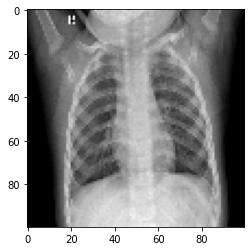

In [4]:
plt.imshow(processed_image[500])

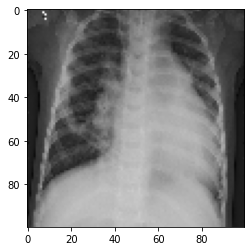

In [5]:
plt.imshow(processed_image[3500])

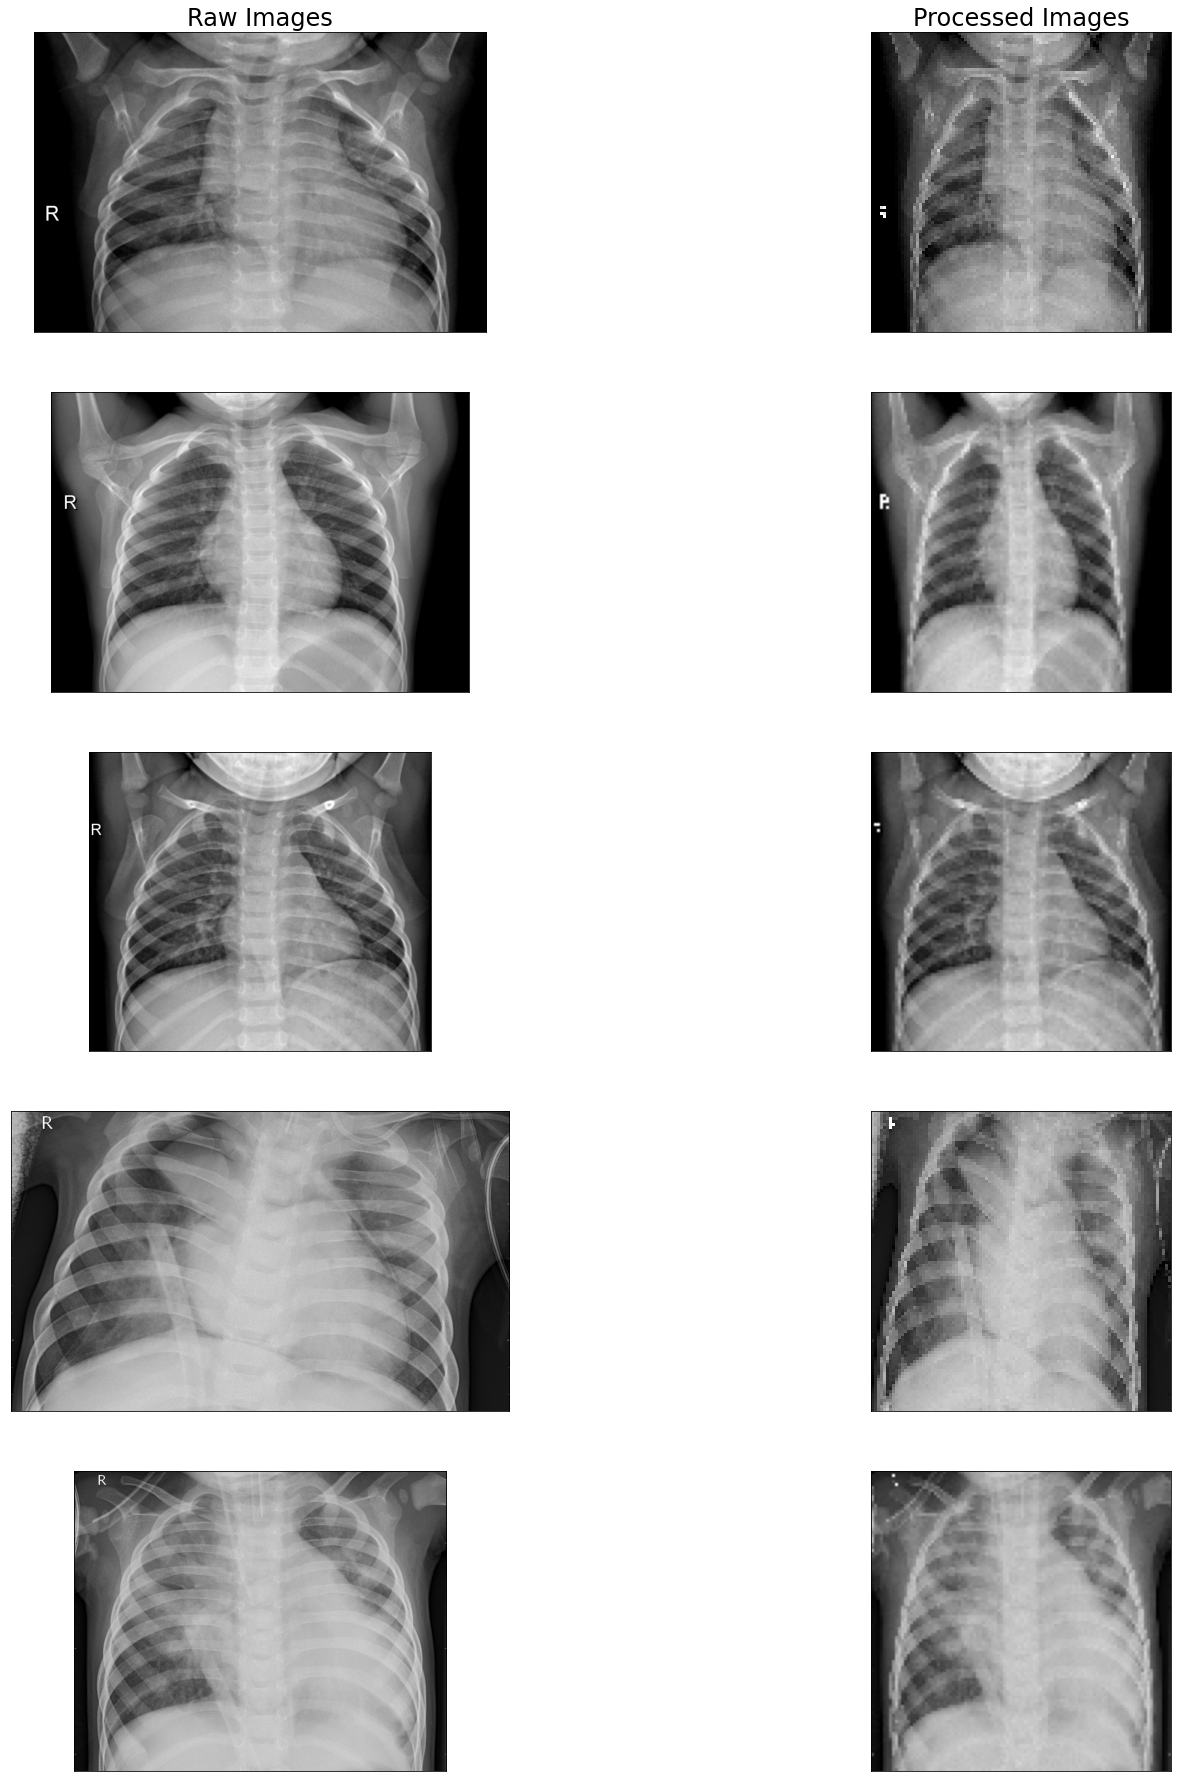

In [6]:
fig = plt.figure(figsize=(25, 32))

ax = fig.add_subplot(5, 2, 1 , xticks=[], yticks=[])
plt.imshow(raw_image[6])
ax.set_title('Raw Images' ,fontsize=24)
ax = fig.add_subplot(5, 2, 2 , xticks=[], yticks=[])
plt.imshow(processed_image[6])
ax.set_title('Processed Images',fontsize=24 )

ax = fig.add_subplot(5, 2, 3 , xticks=[], yticks=[])
plt.imshow(raw_image[350])
ax = fig.add_subplot(5, 2, 4 , xticks=[], yticks=[])
plt.imshow(processed_image[350])

ax = fig.add_subplot(5, 2, 5 , xticks=[], yticks=[])
plt.imshow(raw_image[1000])
ax = fig.add_subplot(5, 2, 6 , xticks=[], yticks=[])
plt.imshow(processed_image[1000])

ax = fig.add_subplot(5, 2, 7 , xticks=[], yticks=[])
plt.imshow(raw_image[3700])
ax = fig.add_subplot(5, 2, 8 , xticks=[], yticks=[])
plt.imshow(processed_image[3700])


ax = fig.add_subplot(5, 2, 9 , xticks=[], yticks=[])
plt.imshow(raw_image[4200])
ax = fig.add_subplot(5, 2, 10 , xticks=[], yticks=[])
plt.imshow(processed_image[4200])

In [7]:
labels = np.array(labels)
# processed_image = processed_image.reshape(processed_image.shape[0],width,height,channel)

In [8]:
labels = np.array(labels)

first_axis = np.shape(processed_image)[0]
array = np.arange(first_axis)
new_array = array
np.shape(array)

np.random.shuffle(new_array)


In [9]:
processed_image = np.array(processed_image)
processed_image = processed_image/255

In [10]:
shuffled_imgs=[]
shuffled_labels=[]

for i in range(len(array)):
    shuffled_imgs.append(processed_image[i]) 
    shuffled_labels.append(labels[i])

In [11]:
np.shape(shuffled_imgs)

shuffled_imgs = np.array(shuffled_imgs)
shuffled_labels = np.array(shuffled_labels)

In [12]:
# LABELS: One-hot encoding 

labels = np.reshape(labels, (-1,1))

print(labels.shape)


unique_category_count = 2 
input_label = tf.one_hot(labels,unique_category_count )
input_label = np.squeeze(input_label,axis=1)


print(input_label)
print(input_label.shape)


(5216, 1)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
(5216, 2)


In [13]:
print(np.shape(shuffled_imgs))

(5216, 100, 100, 3)


### Creating Training and Test Sets

We split the data set into our training and test sets which will be randomly selected having a 80-20% splt. We will use the training set to train our model, and use our test set as the unseen data that will be a useful final metric to let us know how well our model does.


In [14]:
from sklearn.model_selection import train_test_split
image_train, image_test, label_train, label_test = train_test_split(shuffled_imgs, input_label, test_size=0.15, random_state=4)

# Keras Model

In [15]:
channel =3
# KERAS Model, Setup
Keras_model = models.Sequential()

  # Layer 1
Keras_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = "same", input_shape = (width, height,channel))) # kernel
Keras_model.add(layers.MaxPooling2D((2, 2)))

  # Layer 2
Keras_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
Keras_model.add(layers.MaxPooling2D((2, 2)))
Keras_model.add(Flatten())
  # Layer 3
Keras_model.add(Dense(128, input_dim=20, activation='relu'))
Keras_model.add(Dropout(0.5))
Keras_model.add(Dense(64, activation='relu'))
Keras_model.add(Dropout(0.5))
Keras_model.add(Dense(2, activation='softmax'))


Keras_model.compile(optimizer='adam',
              loss = "categorical_crossentropy",
              metrics=['accuracy'])

In [16]:
# KERAS Model, Summary
print('Keras Model:')
Keras_model.summary()

Keras Model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4718720   
_________________________________________________________________
dropout (Dropout)            (None, 128)   

In [17]:
print(np.shape(label_train))
print(np.shape(label_test))
print(np.shape(shuffled_imgs))
print(np.shape(shuffled_labels))


(4433, 2)
(783, 2)
(5216, 100, 100, 3)
(5216,)


In [18]:
# KERAS Model, Run
Keras_history = Keras_model.fit(image_train, label_train, batch_size= 32, epochs=30, validation_data=(image_test, label_test))

Train on 4433 samples, validate on 783 samples
Epoch 1/30
4433/4433 [==============================] - 9s 2ms/sample - loss: 0.3749 - accuracy: 0.8351 - val_loss: 0.1647 - val_accuracy: 0.9349
Epoch 2/30
4433/4433 [==============================] - 3s 759us/sample - loss: 0.1716 - accuracy: 0.9420 - val_loss: 0.1470 - val_accuracy: 0.9451
Epoch 3/30
4433/4433 [==============================] - 3s 767us/sample - loss: 0.1333 - accuracy: 0.9556 - val_loss: 0.1007 - val_accuracy: 0.9617
Epoch 4/30
4433/4433 [==============================] - 3s 755us/sample - loss: 0.1024 - accuracy: 0.9639 - val_loss: 0.0902 - val_accuracy: 0.9693
Epoch 5/30
4433/4433 [==============================] - 3s 756us/sample - loss: 0.0910 - accuracy: 0.9714 - val_loss: 0.0808 - val_accuracy: 0.9757
Epoch 6/30
4433/4433 [==============================] - 3s 757us/sample - loss: 0.0793 - accuracy: 0.9700 - val_loss: 0.0921 - val_accuracy: 0.9642
Epoch 7/30
4433/4433 [==============================] - 3s 765us/sa

In [19]:
Keras_history_dict = Keras_history.history
print(Keras_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


783/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

KERAS, test loss: 0.17403174090433393


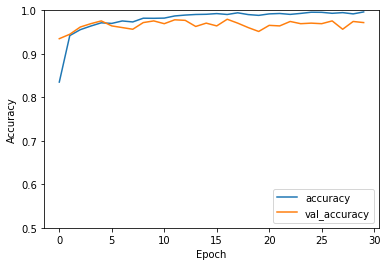

In [20]:

# KERAS Model, Plot
plt.plot(Keras_history.history['accuracy'], label='accuracy')
plt.plot(Keras_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = Keras_model.evaluate(image_test,  label_test, verbose=1)
print("KERAS, test loss:", test_loss)

# Model DenseNet

In [21]:
densenet = DenseNet121(
    weights='DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(100,100,3)
)

In [22]:
def build_model():
    Dense_model = Sequential()
    Dense_model.add(densenet)
    Dense_model.add(layers.GlobalAveragePooling2D())
    Dense_model.add(layers.Dropout(0.5))
    Dense_model.add(layers.Dense(2, activation='sigmoid'))
    
    Dense_model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return Dense_model

In [23]:
Dense_model = build_model()
Dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 7,039,554
Trainable params: 6,955,906
Non-trainable params: 83,648
_________________________________________________________________


In [24]:
Dense_history = Dense_model.fit(image_train, label_train, batch_size= 32, epochs=20, validation_data=(image_test, label_test))

Train on 4433 samples, validate on 783 samples
Epoch 1/20
4433/4433 [==============================] - 61s 14ms/sample - loss: 0.3456 - accuracy: 0.8625 - val_loss: 0.2776 - val_accuracy: 0.9202
Epoch 2/20
4433/4433 [==============================] - 26s 6ms/sample - loss: 0.0883 - accuracy: 0.9730 - val_loss: 0.3904 - val_accuracy: 0.8333
Epoch 3/20
4433/4433 [==============================] - 26s 6ms/sample - loss: 0.0503 - accuracy: 0.9841 - val_loss: 0.2295 - val_accuracy: 0.9049
Epoch 4/20
4433/4433 [==============================] - 26s 6ms/sample - loss: 0.0307 - accuracy: 0.9903 - val_loss: 0.0863 - val_accuracy: 0.9668
Epoch 5/20
4433/4433 [==============================] - 26s 6ms/sample - loss: 0.0158 - accuracy: 0.9964 - val_loss: 0.0751 - val_accuracy: 0.9770
Epoch 6/20
4433/4433 [==============================] - 26s 6ms/sample - loss: 0.0348 - accuracy: 0.9918 - val_loss: 0.0809 - val_accuracy: 0.9738
Epoch 7/20
4433/4433 [==============================] - 26s 6ms/sample

In [25]:
Dense_history_dict = Dense_history.history
print(Dense_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


783/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

KERAS, test loss: 0.06256052557988441


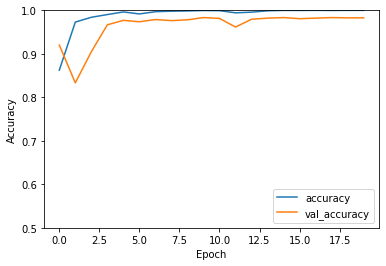

In [26]:
# DensNEt Model, Plot
plt.plot(Dense_history.history['accuracy'], label='accuracy')
plt.plot(Dense_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = Dense_model.evaluate(image_test,  label_test, verbose=1)
print("KERAS, test loss:", test_loss)